In [1]:
# import relevant modules

import numpy as np
import matplotlib.pyplot as plt

## The ocean recharge oscillator ##

This report describes the process of modelling the ocean recharge oscillator (ROM), a reduced coupled model for ENSO illustrating the effects of nonlinearity and forcing, based on the model of Fei-Fei Jin (1997a).

### Governing equations ###

Jin's (1997b) ROM is described by two ordinary differential equations

$$ \frac{dh_w}{dt} = -rh_w - \alpha b T_e - \alpha \xi_1 $$

$$ \frac{dT_E}{dt} = R T_E + \gamma h_w - e_n(h_w + bT_E)^3 + \gamma \xi_1 + \xi_2 $$

where the prognostic variables are $T_E$ (east Pacific SST anomaly) and $h_W$ (west Pacific
ocean thermocline depth) and other variables are defined in the cell below.

For Task A, we consider the neutrial linear (deterministic) ROM, without external forcing ($\xi_{1,2} = 0$) or nonlinearity ($e_n = 0$). The ODEs above reduce to:

$$ \frac{dh_w}{dt} = -rh_w - \alpha b T_e $$

$$ \frac{dT_E}{dt} = R T_E + \gamma h_w $$

In [2]:
# define the global variables

# non-dimensionalised parameters

T_nd = 7.5 # SST anomaly-scale (kelvin)
h_nd = 150 # thermocline depth scale (m)
t_nd = 2*30*24*60*60 # time-scale - 2 months in seconds

# define the variables for Task A - neutral linear (deterministic) ROM

mu_c = 2/3 # critical value for the coupling parameter
mu = mu_c # set the coupling value to its critical parameter
b_0 = 2.5 # high end value for the coupling parameter
b = b_0*mu # measure of the thermocline slope
gamma = 0.75 # feedback of the thermocline gradient on the SST gradient
c = 1 # damping rate of SST anomalies
R = gamma*b - c # describes the Bjerknes positive feedback process
r = 0.25 # damping of upper ocean heat content
alpha = 0.125 # relates enhanced easterly wind stress to the recharge of ocean heat content
e_n = 0 # degree of nonlinearity of ROM
xi_1 = 0 # random wind stress forcing added to the system
xi_2 = 0 # random heating added to the system

dt = 0.1 # time interval - two months split into 10 equal slices

The most simple time scheme is the explicit euler. The consistency condition forces us to choose $$\alpha_n = 1$$
Given this consistency condition, the scheme reduces to 
$$ \frac{q^{n+1} - q^n}{\Delta t} = f^n$$
Where the truncation error is given by
$$ \frac{\Delta t}{2}q'' + O(\Delta t^2) = O(\Delta t)$$
Therefore the scheme has first order accuracy

For the neutral linear (deterministic) ROM in task A, the explict euler scheme is given by the following coupled equations:

$$ T_E^{N+1} = T_E^N + \Delta{t}(RT_E^N + \gamma h_w^N) $$

$$ h_w^{N+1} = h_w^N - \Delta t(rh_w^N + \alpha b T_e^N) $$

In [3]:
# write a function for the simple explicit euler function
def euler(T_init, h_init, mu, R, gamma, e_n, xi_1, xi_2, dt, nt):
    """Explicit euler scheme for solving the ocean recharge oscillator model using finite differences. Takes T, the SST anomaly, h, the thermocline depth scale, t, the time scale, mu, the coupling value, R, the bjerkness positive feedback, gamma, the feedback of the thermocline gradient on the SST gradient, e_n, the degree of nonlinearity xi_1 and xi_2, the random wind stress and random heating added to the system, dt, the time step size and nt, the number of time steps."""

    # initialize arrays to store the results
    time = np.zeros(nt)
    T_e = np.zeros(nt)
    h_w = np.zeros(nt)

    # set the initial conditions
    T_e[0] = T_init
    h_w[0] = h_init
    time[0] = 0

    # step forward in time with the explicit euler scheme
    for i in range(1,nt):

        time[i] = i * dt
        
        # for T - SST anomaly scale
        T_e[i] = T_e[i-1] + dt*(R*T_e[i-1] + gamma*h_w[i-1])

        # for h - thermocline depth scale
        h_w[i] = h_w[i-1] + dt*(r*h_w[i-1] - alpha*b*T_e[i-1])
    
    return T_e, h_w, time

The explicit euler method can be modified to obtain better accuracy through proper choice of the $\alpha$ 's, if we use $l > 0$. If we consider the case $l=1$. This scheme is known as Adams-Bashforth, and reduces to

$$ \frac{q^{n+1} - q^n}{\Delta t} = \alpha_n f^n + \alpha_{n-1}f^{n+1} $$

The consistency condition reduces to

$$ \alpha_n + \alpha_{n+1} = 1 $$

And the truncation error is

$$ \varepsilon = \Delta t q'' \biggl( \alpha_{n-1} + \frac{1}{2} \biggr) + O(\Delta t^2) $$

Giving second order accuracy

For the neutral linear (deterministic) ROM in task A, the Adams-Bashforth scheme is given by the following coupled equations:

$$ T_E^{N+1} = T_E^N + \Delta{t} \biggl(\frac{3}{2}(RT_E^N + \gamma h_w^N) - \frac{1}{2} (RT_E^{N-1} + \gamma h_w^{N-1}) \biggr) $$

$$ h_w^{N+1} = h_w^N + \Delta t \biggl(-\frac{3}{2}(rh_w^N + \alpha b T_e^N) + \frac{1}{2}(rh_w^{N-1} + \alpha b T_e^{N-1}) \biggr) $$

In [4]:
# define a function for the modified euler scheme
def adams_bashforth(T_init, h_init, mu, R, gamma, e_n, xi_1, xi_2, dt, nt):
    """Modified euler scheme to give Adams-Bashforth time scheme for modelling the ocean recharge oscillator model using finite difference. Should give second order accuracy. Takes T, the SST anomaly, h, the thermocline depth scale, t, the time scale, mu, the coupling value, R, the bjerknes positive feedback, gamma, the feedback of the thermocline gradient on  the SST gradient, e_n, the degree of nonlinearity xi_1 and xi_2, the random wind stress and random heating added to the system, dt, the size of the timestep and nt, the number of timesteps."""

    # initialize arrays to store the results
    time = np.zeros(nt)
    T_e = np.zeros(nt)
    h_w = np.zeros(nt)

    # set the initial conditions
    T_e[0] = T_init
    h_w[0] = h_init
    time[0] = 0
    
    b = b_0*mu
    
    # calculate the 1th value using the explicit euler
    T_e[1] = T_e[0] + dt*(R*T_e[0] + gamma*h_w[0])
    h_w[1] = h_w[0] + dt*(r*h_w[0] + alpha*b*T_e[0])
    time[1] = dt
    
    # step forward in time with the Adams-Bashforth scheme
    for i in range(2,nt):
        
        # time variable
        time[i] = i * dt
        
        # for T - SST anomaly scale
        T_e[i] = T_e[i-1] + dt*(3/2*(R*T_e[i-1] + gamma*h_w[i-1]) - 1/2*(R*T_e[i-2] + gamma*h_w[i-2]))

        # for h - thermocline depth scale
        h_w[i] = h_w[i-1] + dt*(-3/2*(r*h_w[i-1] + alpha*b*T_e[i-1]) + 1/2*(r*h_w[i-2] + alpha*b*T_e[i-2]))
    
    return T_e, h_w, time

The trapezoidal implicit scheme has second order accuracy and is given by

$$ \frac{q^{n+1} - q^n}{\Delta t} = \beta f^{n+1} + \alpha_n f^n $$

With coefficients

$$ \beta = \alpha = \frac{1}{2} $$

And truncation error

$$ \varepsilon = \Delta t q''\biggl(\frac{1}{2} - \beta \biggr) + O(\Delta t^2) $$

For the neutral linear (deterministic) ROM in task A, the trapezoidal scheme is given by the following coupled equations:

$$ T_e^{n+1} = T_e^{n} + \frac{\Delta t}{2} \biggl((RT_e^{n+1} + \gamma h_w^{n+1}) + (RT_e^{n} + \gamma h_w^{n})\biggr) $$

$$ h_w^{n+1} = h_w^{n} - \frac{\Delta t}{2} \biggl((rh_w^{n+1} + \alpha b T_e^{n+1}) + (rh_w^{n} + \alpha b T_e^{n+1}) \biggr) $$


In [5]:
# define a function for the implicit trapezoidal scheme
def trapezoidal(T_init, h_init, mu, R, gamma, e_n, xi_1, xi_2, dt, nt):
    """Implicit trapezoidal finite difference scheme for modelling the ocean recharge oscillator model. Takes T_init, the initial SST anomaly, h_init, the initial thermocline depth scale, mu, the coupling value, R, the bjerknes positive feedback, gamma, the feedback of the thermocline gradient on the SST gradient, e_n, the degree of nonlinearity xi_1 and xi_2, the random wind stress and random heating added to the system, dt, the size of the time steps and nt the number of time steps."""
    
    # initialize arrays to store the results
    time = np.zeros(nt)
    T_e = np.zeros(nt)
    h_w = np.zeros(nt)

    # set the initial conditions
    T_e[0] = T_init
    h_w[0] = h_init
    time[0] = 0

    # step forward in time with the general implementation of the implicit trapezoidal scheme
    for i in range(1,nt):
        
        # time variable
        time[i] = i * dt
        
        # for T - SST anomaly scale
        T_e[i] = T_e[i-1] + dt/2*((R*T_e[i] + gamma*h_w[i]) + (R*T_e[i-1] + gamma*h_w[i-1]))

        # for h - thermocline depth scale
        h_w[i] = h_w[i-1] - dt/2*((r*h_w[i] + alpha*b*T_e[i]) + (r*h_w[i-1] + alpha*b*T_e[i-1]))
    
    return T_e, h_w, time

One example of an iterative "predictor-corrector" time schemes is the fourth order accurate Runge-Kutta, which is given by

$$ q^{n+1} = q^n + \Delta t \frac{1}{6} \bigl(k_1 + 2k_2 + 2k_3 + k_4 \bigr) $$

Where the $k$'s are given by

$$ k_1 = f(q^n,n \Delta t) $$

$$ k_2 = f \biggl[q^n + \frac{k_1 \Delta t}{2}, \biggl(n+\frac{1}{2} \biggr) \Delta t \biggr] $$

$$ k_3 = f \biggl[q^n + \frac{k_2 \Delta t}{2}, \biggl(n+\frac{1}{2} \biggr) \Delta t \biggr] $$

$$ k_4 = f \bigl[q^n + k_3 \Delta t,(n+1) \Delta t \bigr] $$

Each of the $k$'s can be interpreted as an approximation to $f$. Each of the $k$'s have to be evaluated successively, which means that the function $f$ has to be evaluated four times to take one time step. None of these $f$'s can be "re-used" on the next timestep. For this reason, long time steps should be used with this scheme.

Let's consider the simple implementation of the four step Runge-Kutte for Task A where K and l represent the components of T and h respectively.

$$ k_1 = f(T_e,h_w,t) $$

$$ l_1 = f(T_e,h_w,t) $$

Where $k$ and $l$ are approximations to a coupled set of functions $f$ which can be expressed as a function of T_e, the temperature, h_w, the thermocline depth and t, the timestep. For the simple ROM, $k_1$ and $l_1$ are given by:

$$ k_1 =  R T_E + \gamma h_w $$

$$ l_1 = -rh_w - \alpha b T_e $$

Thus, it follows that $k_2$, $k_3$ and $k_4$ (and their $l$'s) are given by the following:

$$ k_2 = R \biggl(T_e + \frac{k_1 \Delta t}{2} \biggr) + \gamma \biggl(h_w + \frac{l_1 \Delta t}{2} \biggr) $$

$$ l_2 = -r \biggl(h_w + \frac{l_1 \Delta t}{2} \biggr) - \alpha b \biggl(T_e + \frac{k_1 \Delta t}{2} \biggr) $$

$$ k_3 = R \biggl(T_e + \frac{k_2 \Delta t}{2} \biggr) + \gamma \biggl(h_w + \frac{l_2 \Delta t}{2} \biggr) $$

$$ l_3 = -r \biggl(h_w + \frac{l_2 \Delta t}{2} \biggr) - \alpha b \biggl(T_e + \frac{k_2 \Delta t}{2} \biggr) $$

$$ k_4 = R (T_e + k_3 \Delta t) + \gamma (h_w + l_3 \Delta t ) $$

$$ l_4 = -r (h_w + l_3 \Delta t) - \alpha b (T_e + k_3 \Delta t) $$


In [6]:
# define the function for the fourth-order Runge-Kutta scheme
def rk4(f, y0, t):
    """
    Solve a system of ordinary differential equations using the RK4 method.
    f: function that defines the system of ODEs.
    y0: initial condition.
    t: array of equally spaced time points for which to solve the ODE.
    """
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0
    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1 = h * f(y[i], t[i])
        k2 = h * f(y[i] + 0.5 * k1, t[i] + 0.5 * h)
        k3 = h * f(y[i] + 0.5 * k2, t[i] + 0.5 * h)
        k4 = h * f(y[i] + k3, t[i + 1])
        y[i + 1] = y[i] + (k1 + 2 * k2 + 2 * k3 + k4) / 6
    return y

To run the RK4 function above, we must define the system of ODE's used for the recharge oscillator model of ENSO (for the neutral linear deterministic ROM).

In [7]:
# define the function of ODEs
def enso(y, t):
    """
    Define the system of ODEs for the recharge oscillator model of ENSO.
    y: array of state variables [T, S].
    t: time.
    """
    
    # define the simple ODEs for Task A
    dTdt = R * y[0] + gamma * y[1]
    dSdt = -r * y[1] - alpha * b * y[0]

    return np.array([dTdt, dSdt])

Now we want to call the functions for the four schemes (explicit euler, adams-bashforth, trapezoidal and RK4) to create plots for the neutral linear ROM.

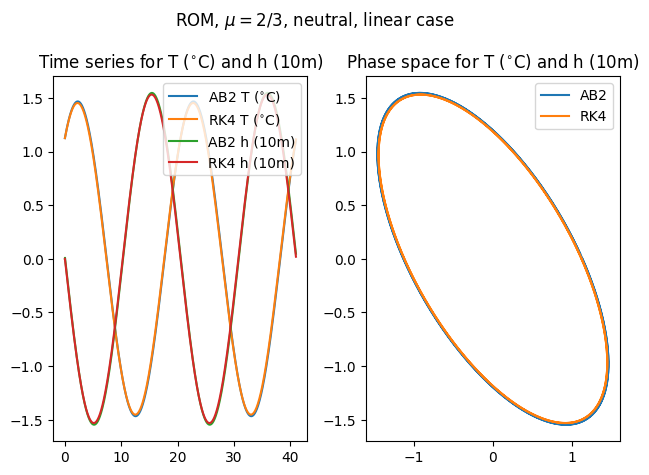

<Figure size 640x480 with 0 Axes>

In [8]:
# call the functions and create plots

# define the time-step parameters
dt = 0.02
nt = int(41 / 0.02)
t = np.linspace(0, 41, nt)

# define the non-dimensionalised initial conditions for the three schemes
# euler, AB2 and trapezoidal
T_init = 1.125/7.5
h_init = 0/150

# define the non-dimensionalised initial conditions for the RK4 scheme
y0 = [1.125 / 7.5, 0 / 150]
# initialize the RK4 scheme
y = rk4(enso, y0, t)
sst_anomaly_rk, thermocline_depth_rk = y[:, 0], y[:, 1]

# run the other implementations: euler, AB2 and trapezoidal
sst_anomaly, thermocline_depth, time = euler(T_init, h_init, mu, R, gamma, e_n,
                                             xi_1, xi_2, dt, nt)
sst_anomaly_ab, thermocline_depth_ab, time_ab = adams_bashforth(T_init, h_init,
                                                                mu, R, gamma, e_n, xi_1, xi_2, dt, nt)
sst_anomaly_tz, thermocline_depth_tz, time_tz = trapezoidal(T_init, h_init,
                                                            mu, R, gamma, e_n, xi_1, xi_2, dt, nt)

# redimensionalise the results
# for all of the sst_anomaly results, multiply by 7.5
sst_anomaly = sst_anomaly * 7.5
sst_anomaly_ab = sst_anomaly_ab * 7.5
sst_anomaly_tz = sst_anomaly_tz * 7.5
sst_anomaly_rk = sst_anomaly_rk * 7.5

# for all of the thermocline_depth results, multiply by 150 to redimensionalise
# then divide by 10 to convert to units of 10m
thermocline_depth = thermocline_depth * 150/10
thermocline_depth_ab = thermocline_depth_ab * 150/10
thermocline_depth_tz = thermocline_depth_tz * 150/10
thermocline_depth_rk = thermocline_depth_rk * 150/10

# now plot the results as a time series
# specify labels for each of the schemes used
# first for a time series plot, for both the sst anomaly and thermocline depth
# using one y-axis
# specify two subplots in a 2x1 grid
fig, (ax1, ax2) = plt.subplots(1, 2)
# plot all of the SST anomaly results
#ax1.plot(time, sst_anomaly, label='Euler T ($^{\circ}$C)')
ax1.plot(time, sst_anomaly_ab, label='AB2 T ($^{\circ}$C)')
#ax1.plot(time, sst_anomaly_tz, label='Trapezoidal T ($^{\circ}$C)')
ax1.plot(time, sst_anomaly_rk, label='RK4 T ($^{\circ}$C)')
# plot all of the thermocline depth results
#ax1.plot(time, thermocline_depth, label='Euler h (10m)')
ax1.plot(time, thermocline_depth_ab, label='AB2 h (10m)')
#ax1.plot(time, thermocline_depth_tz, label='Trapezoidal h (10m)')
ax1.plot(time, thermocline_depth_rk, label='RK4 h (10m)')
# set the plot title as '$\mu$ = 2/3, neutral, linear case'
ax1.title.set_text('Time series for T ($^{\circ}$C) and h (10m)')
# specify the legend in the top right hand corner
ax1.legend(loc='upper right')

# now plot the phase space plot for all of the schemes using ax2
#ax2.plot(sst_anomaly, thermocline_depth, label='Euler')
ax2.plot(sst_anomaly_ab, thermocline_depth_ab, label='AB2')
#ax2.plot(sst_anomaly_tz, thermocline_depth_tz, label='Trapezoidal')
ax2.plot(sst_anomaly_rk, thermocline_depth_rk, label='RK4')
# set the plot title as '$\mu$ = 2/3, neutral, linear case'
# set a font size of 8
ax2.title.set_text('Phase space for T ($^{\circ}$C) and h (10m)')
# specify the legend in the top right hand corner
ax2.legend(loc='upper right')

# specify a suptitle for the plot
plt.suptitle('ROM, $\mu = 2/3$, neutral, linear case')

# specify a tight layout
plt.tight_layout()

# show the plot
plt.show()

# save the plot as 'combined_plot.png', specify high resolution png
plt.savefig('combined_plot.png')

The adams-bashforth (modified euler) and RK4 schemes appear to show stable output for the time series and trajectory plots. The explicit euler appears unstable, so is plotted below.

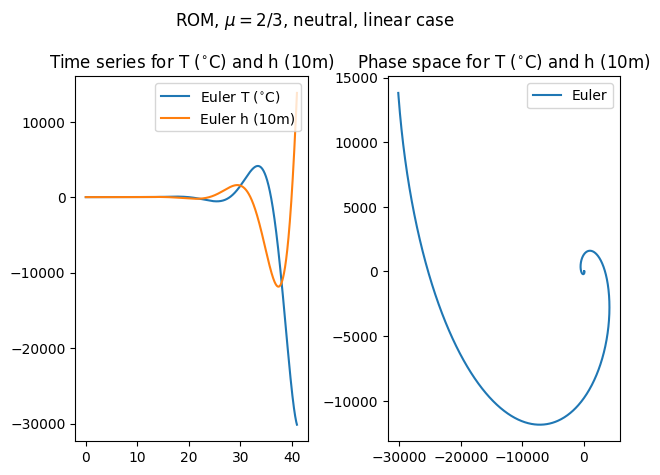

<Figure size 640x480 with 0 Axes>

In [9]:
# plot the explicit euler results
fig, (ax1, ax2) = plt.subplots(1, 2)

# plot all of the SST anomaly results
ax1.plot(time, sst_anomaly, label='Euler T ($^{\circ}$C)')
# plot all of the thermocline depth results
ax1.plot(time, thermocline_depth, label='Euler h (10m)')

# set the plot title as '$\mu$ = 2/3, neutral, linear case'
ax1.title.set_text('Time series for T ($^{\circ}$C) and h (10m)')
# specify the legend in the top right hand corner
ax1.legend(loc='upper right')

# now plot the phase space plot for all of the schemes using ax2
ax2.plot(sst_anomaly, thermocline_depth, label='Euler')

# set the plot title as '$\mu$ = 2/3, neutral, linear case'
ax2.title.set_text('Phase space for T ($^{\circ}$C) and h (10m)')
# specify the legend in the top right hand corner
ax2.legend(loc='upper right')

# specify a suptitle for the plot
plt.suptitle('ROM, $\mu = 2/3$, neutral, linear case')

# specify a tight layout
plt.tight_layout()

# show the plot
plt.show()

# save the plot as 'combined_plot.png', specify high resolution png
plt.savefig('combined_plot_euler.png')

The trapezoidal scheme shows similar results to AB2 and RK4, and appears to be stable, however the time series appears to have a slightly different magnitude to the RK4 and AB2 schemes. The result is similar for the trajectory plot.

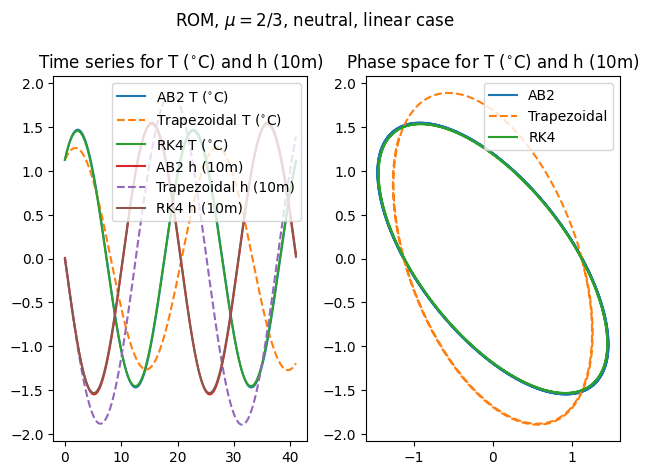

<Figure size 640x480 with 0 Axes>

In [10]:
# plot the implici trapezoidal scheme alongside the AB2 and RK4 schemes
fig, (ax1, ax2) = plt.subplots(1, 2)

# plot all of the SST anomaly results
ax1.plot(time, sst_anomaly_ab, label='AB2 T ($^{\circ}$C)')
ax1.plot(time, sst_anomaly_tz, label='Trapezoidal T ($^{\circ}$C)',linestyle='--')
ax1.plot(time, sst_anomaly_rk, label='RK4 T ($^{\circ}$C)')

# plot all of the thermocline depth results
ax1.plot(time, thermocline_depth_ab, label='AB2 h (10m)')
ax1.plot(time, thermocline_depth_tz, label='Trapezoidal h (10m)',linestyle='--')
ax1.plot(time, thermocline_depth_rk, label='RK4 h (10m)')

# set the plot title
ax1.title.set_text('Time series for T ($^{\circ}$C) and h (10m)')
# specify the legend in the top right hand corner
ax1.legend(loc='upper right')

# now plot the phase space plot for all of the schemes using ax2
ax2.plot(sst_anomaly_ab, thermocline_depth_ab, label='AB2')
ax2.plot(sst_anomaly_tz, thermocline_depth_tz, label='Trapezoidal',linestyle='--')
ax2.plot(sst_anomaly_rk, thermocline_depth_rk, label='RK4')

# set the plot title 
ax2.title.set_text('Phase space for T ($^{\circ}$C) and h (10m)')
# specify the legend in the top right hand corner
ax2.legend(loc='upper right')

# specify a suptitle for the plot
plt.suptitle('ROM, $\mu = 2/3$, neutral, linear case')

# specify a tight layout
plt.tight_layout()

# show the plot
plt.show()

# save the plot as 'combined_plot.png', specify high resolution png
plt.savefig('combined_plot_AB2_Trap_RK4.png')

#### Stability Analysis ####

To analyse the stability of the schemes, we must first construct A, an amplification matrix, such that:

$$ \begin{pmatrix} T_{n+1} \\ h_{n+1} \end{pmatrix} = A \begin{pmatrix} T_{n} \\ h_{n} \end{pmatrix} $$

We must then find the eigenvalues at A. If the magnitude of the eigenvalues at A are greater than 1 (when plotting against the time step), this would suggest that the scheme is becoming increasingly unstable as the time step size is increasing. 

[0.         1.005      1.00492128 ... 1.41829756 1.42332724 1.428329  ]


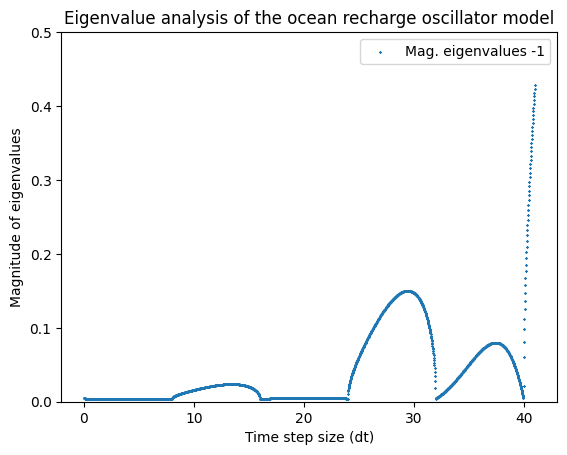

[0.00000000e+00 1.02500000e+00 1.02215095e+00 ... 2.24087524e+09
 2.39552087e+09 2.54565982e+09]


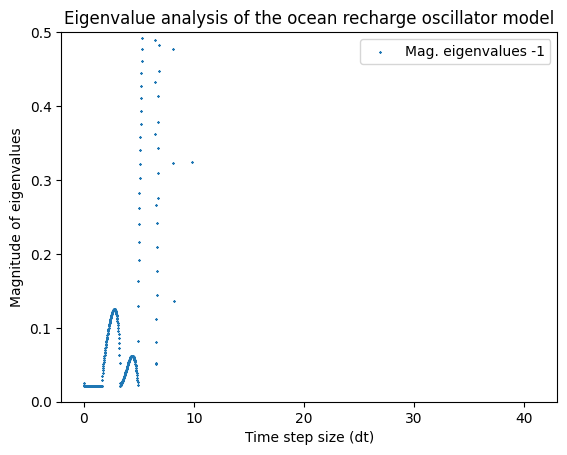

[0.00000000e+00 1.12500000e+00 1.10485435e+00 ... 1.02306239e+58
 1.17158483e+58 1.31256045e+58]


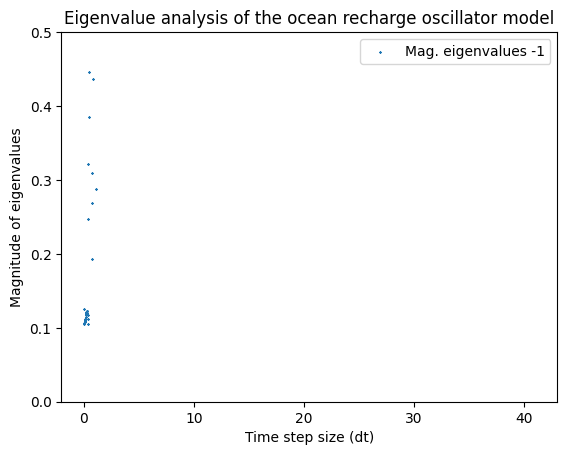

[0.00000000e+000 1.25000000e+000 1.21406686e+000 ... 4.06045720e+119
 4.61421110e+119 4.98896696e+119]


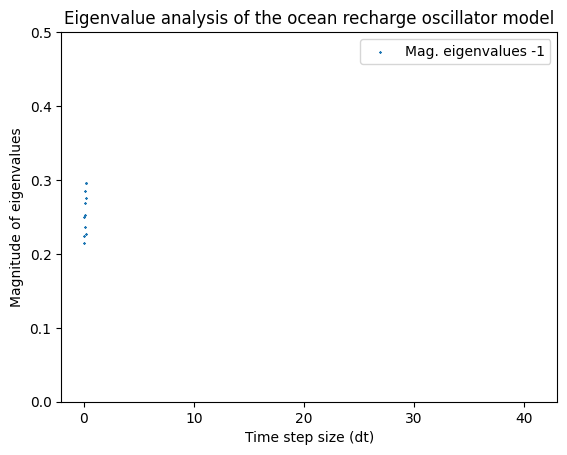

array([0.00000000e+000, 1.25000000e+000, 1.21406686e+000, ...,
       4.06045720e+119, 4.61421110e+119, 4.98896696e+119])

<Figure size 640x480 with 0 Axes>

In [11]:
# using this above, we want to show that the two euler schemes are either:
# for explicit euler - unstable for all values of dt
# for adams-bashforth - hopefully stable for all values of dt

dt = 0.02

# define the function to perform the eigenvalue analysis

def eigenvalue_analysis(T_init, h_init, mu, R, gamma, e_n, xi_1, xi_2, dt, nt):
    T_e, h_w, time = euler(T_init, h_init, mu, R, gamma, e_n, xi_1, xi_2, dt, nt)
    
    # Initialize an array to store the magnitude of the eigenvalues
    mag_eigenvalues = np.zeros(nt)
    
    # Loop over each time step
    for i in range(1, nt):
        system_matrix = np.array([[1 + dt*R, dt*gamma], [dt*mu*h_w[i-1], 1 + dt*mu*R]])
        eigenvalues = np.linalg.eigvals(system_matrix)
        mag_eigenvalues[i] = np.abs(eigenvalues).max()
    
    print(mag_eigenvalues)
    # Plot the magnitude of the eigenvalues against the time step size
    plt.scatter(t, mag_eigenvalues-1,s=1, marker='x',label = 'Mag. eigenvalues -1')
    plt.xlabel('Time step size (dt)')
    plt.ylabel('Magnitude of eigenvalues')
    plt.title('Eigenvalue analysis of the ocean recharge oscillator model')
    plt.axhline(y=1, color='r', linestyle='--')
    plt.ylim(0.0,0.5)
    plt.legend(loc='best')
    plt.show()
    plt.savefig('stability_analysis_explicit_euler.png')
    
    return mag_eigenvalues
    
    
# test the function
eigenvalue_analysis(T_init, h_init, mu, R, gamma, e_n, xi_1, xi_2, dt, nt)
eigenvalue_analysis(T_init, h_init, mu, R, gamma, e_n, xi_1, xi_2, 0.1, nt)
eigenvalue_analysis(T_init, h_init, mu, R, gamma, e_n, xi_1, xi_2, 0.5, nt)
eigenvalue_analysis(T_init, h_init, mu, R, gamma, e_n, xi_1, xi_2, 1.0, nt)

Euler scheme is unstable as the magnitude of the eigenvalues are greater than 1 for dt of (0.02, 0.1, 0.5, 1.0). The scheme becomes more unstable more rapidly with a larger timestep.

In [12]:
# import the packages for SimPy stability analysis

from IPython.display import display, Latex, Math
import sympy
from sympy import *
from sympy.matrices import Matrix
init_printing(use_latex='mathjax')

In [13]:
# perform the stability analysis of the euler scheme using SimPy

# EULER SCHEME
Psi = sympy.symbols('Psi') # these are the symbols to solve for
R, Dt, gamma, alpha, b, r = sympy.var('R, Dt, gamma, alpha, b, r') #
#M=Matrix(([[Psi-1-R*Dt,-gamma*Dt],[alpha*b*Dt,Psi-1+r*Dt]]))
M=Matrix(([[Psi-1-R*Dt,-gamma*Dt],[alpha*b*Dt,Psi-1+R*Dt]])) # special case of mu=2/3 so R=r
#pprint(M)
#display(M)
display(Math("{Matrix}\ M:\ " + latex(M)))
equation=M.det()
Solution=solve(equation,Psi)
#pprint(Solution)
Psi_plus=Solution[1]
Psi_minus=Solution[0]
print(" ")
#print("Psi positive solution: ")
display(Math("\Psi \ positive\ solution:\ " + latex(Psi_plus)))
display(Math("\Psi \ negative\ solution:\ " + latex(Psi_minus)))
print(" ")
mu=2./3.
b_0=2.5
b_val=b_0/mu
gamma_val=0.75
alpha_val=0.25
r_val=0.125
c_val=1.0
R_val=gamma_val*b_val - c_val
Psi_solution_plus = Psi_plus.subs([(R,R_val), (r,r_val)])
Psi_solution_minus = Psi_minus.subs([(R,R_val), (r,r_val)])
#print(" ")
##print("Psi positive solution: ")
#pprint(Psi_solution_plus)
#print(" ")
#print("$\Psi$ negative solution: ")
#pprint(Psi_solution_minus)
lambda_squared = 1 + (alpha*gamma*b -R*r)*Dt**2
display(Math("Analytic\ expression\ for\ \lambda^2 :\ " + latex(lambda_squared)))
#print("Analytic expression for lambda_squared: ")
#pprint(lambda_squared)
lambda_square_solution = lambda_squared.subs([(R,R_val), (r,r_val),(alpha,alpha_val), (gamma, gamma_val), (b,b_val)])
print(" ")
#print("Value of lambda_squared for Euler: ",lambda_square_solution)
display(Math("Value\ of\ \lambda^2 \ for\ Euler:\ " + latex(lambda_square_solution)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Now we are going to work with the assumption that the adams-bashforth and RK4 schemes are stable and move onto task B.

For task B, we will test the behaviour of the ROM with a sub-critical ($\mu > 2/3$) and super-critical ($\mu < 2/3$) value for the coupling parameter, $\mu$.

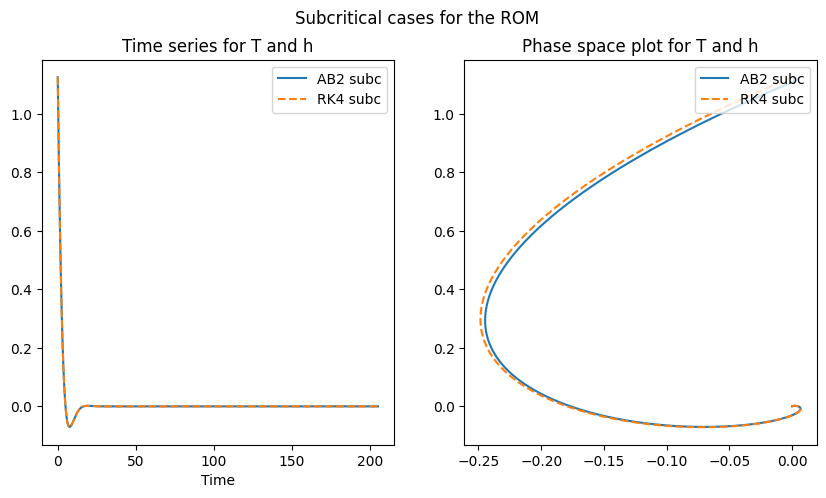

[ 0.00000000e+00 -4.65872310e-03 -9.25925065e-03 ...  8.56687535e-29
  8.45952296e-29  8.35292617e-29]


In [35]:
# define the sub-critical and super critical values of \mu
# redefine the global variables

# define the global variables

# non-dimensionalised parameters

T_nd = 7.5 # SST anomaly-scale (kelvin)
h_nd = 150 # thermocline depth scale (m)
t_nd = 2*30*24*60*60 # time-scale - 2 months in seconds

# define the variables for task B - neutral linear (deterministic) ROM

mu_c = 2/3 # critical value for the coupling parameter
mu_subc = 1/3
mu = mu_subc # set the coupling value to its subcritical parameter
b_0 = 2.5 # high end value for the coupling parameter
b = b_0*mu # measure of the thermocline slope
gamma = 0.75 # feedback of the thermocline gradient on the SST gradient
c = 1 # damping rate of SST anomalies
R = gamma*b - c # describes the Bjerknes positive feedback process
r = 0.25 # damping of upper ocean heat content
alpha = 0.125 # relates enhanced easterly wind stress to the recharge of ocean heat content
e_n = 0 # degree of nonlinearity of ROM
xi_1 = 0 # random wind stress forcing added to the system
xi_2 = 0 # random heating added to the system

# run the RK4 scheme
# define the time-step parameters
dt = 0.02
nt = int(5*41 / 0.02) # for 5 periods
t = np.linspace(0, 5*41, nt)

# define the non-dimensionalised initial conditions for the three schemes
# euler, AB2 and trapezoidal
T_init = 1.125/7.5
h_init = 0/150

# run the AB scheme

sst_anomaly_ab_subc, thermocline_depth_ab_subc, time_ab_subc = adams_bashforth(T_init, h_init,
                                                                mu, R, gamma, e_n, xi_1, xi_2, dt, nt)

# define the non-dimensionalised initial conditions for the RK4 scheme
y0 = [1.125 / 7.5, 0 / 150]
# initialize the RK4 scheme
y_subc = rk4(enso, y0, t)
sst_anomaly_rk_subc, thermocline_depth_rk_subc = y_subc[:, 0], y_subc[:, 1]

# now for the supercritical

mu_supc = 1
mu = mu_supc # set the coupling value to its subcritical parameter
b_0 = 2.5 # high end value for the coupling parameter
b = b_0*mu # measure of the thermocline slope
gamma = 0.75 # feedback of the thermocline gradient on the SST gradient
c = 1 # damping rate of SST anomalies
R = gamma*b - c # describes the Bjerknes positive feedback process

# run the AB scheme

sst_anomaly_ab_supc, thermocline_depth_ab_supc, time_ab_supc = adams_bashforth(T_init, h_init,
                                                                mu, R, gamma, e_n, xi_1, xi_2, dt, nt)

# define the non-dimensionalised initial conditions for the RK4 scheme
y0 = [1.125 / 7.5, 0 / 150]
# initialize the RK4 scheme
y_supc = rk4(enso, y0, t)
sst_anomaly_rk_supc, thermocline_depth_rk_supc = y_supc[:, 0], y_supc[:, 1]

# redimensionalise the results
# for all of the sst_anomaly results, multiply by 7.5
sst_anomaly_ab_subc = sst_anomaly_ab_subc * 7.5
sst_anomaly_ab_supc = sst_anomaly_ab_supc * 7.5
sst_anomaly_rk_subc = sst_anomaly_rk_subc * 7.5
sst_anomaly_rk_supc = sst_anomaly_rk_supc * 7.5

# for all of the thermocline_depth results, multiply by 150 to redimensionalise
# then divide by 10 to convert to units of 10m
thermocline_depth_ab_subc = thermocline_depth_ab_subc * 150/10
thermocline_depth_ab_supc = thermocline_depth_ab_supc * 150/10
thermocline_depth_rk_subc = thermocline_depth_rk_subc * 150/10
thermocline_depth_rk_supc = thermocline_depth_rk_supc * 150/10

# now plot the subcrcitical and supercritical cases for both time series and 
# phase space plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(time_ab_subc, sst_anomaly_ab_subc, label='AB2 subc')
#ax1.plot(time_ab_supc, sst_anomaly_ab_supc, label='AB2 supc')
ax1.plot(t, sst_anomaly_rk_subc, label='RK4 subc',linestyle='--')
#ax1.plot(t, sst_anomaly_rk_supc, label='RK4 supc')
ax1.set_xlabel('Time')
# set the title of the plot
ax1.set_title('Time series for T and h')
# specify the legend in the upper right corner
ax1.legend(loc='upper right')

ax2.plot(thermocline_depth_ab_subc, sst_anomaly_ab_subc, label='AB2 subc')
#ax2.plot(thermocline_depth_ab_supc, sst_anomaly_ab_supc, label='AB2 supc')
ax2.plot(thermocline_depth_rk_subc, sst_anomaly_rk_subc, label='RK4 subc',linestyle='--')
#ax2.plot(thermocline_depth_rk_supc, sst_anomaly_rk_supc, label='RK4 supc')
# set the title of the plot
ax2.set_title('Phase space plot for T and h')
# specify the legend in the upper right corner
ax2.legend(loc='upper right')

# specify a super title for the whole figure
fig.suptitle('Subcritical cases for the ROM')

plt.show()

# save the figure
fig.savefig('subc_cases.png')

print(thermocline_depth_rk_subc)

In the subcritical cases, it appears that the schemes do not complete one full period of oscillation.

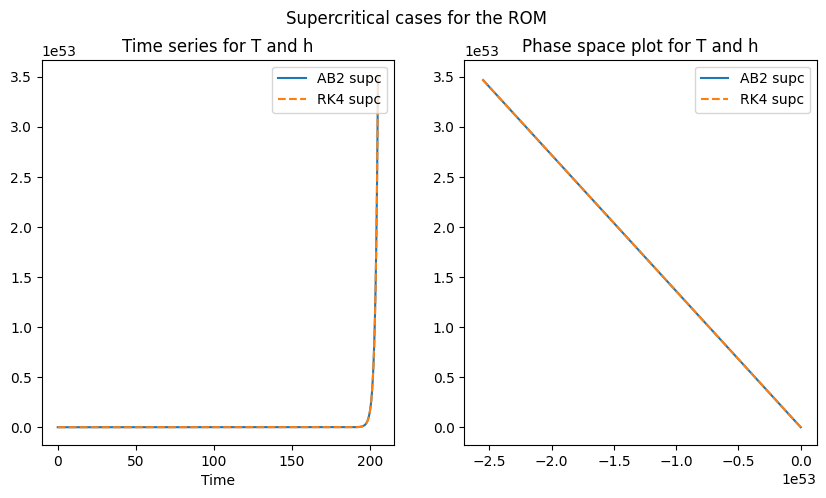

In [34]:
# now plot the supercritical cases for both time series and 
# phase space plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
#ax1.plot(time_ab_subc, sst_anomaly_ab_subc, label='AB2 subc')
ax1.plot(time_ab_supc, sst_anomaly_ab_supc, label='AB2 supc')
#ax1.plot(t, sst_anomaly_rk_subc, label='RK4 subc')
ax1.plot(t, sst_anomaly_rk_supc, label='RK4 supc',linestyle='--')
ax1.set_xlabel('Time')
# set the title of the plot
ax1.set_title('Time series for T and h')
# specify the legend in the upper right corner
ax1.legend(loc='upper right')

#ax2.plot(thermocline_depth_ab_subc, sst_anomaly_ab_subc, label='AB2 subc')
ax2.plot(thermocline_depth_ab_supc, sst_anomaly_ab_supc, label='AB2 supc')
#ax2.plot(thermocline_depth_rk_subc, sst_anomaly_rk_subc, label='RK4 subc')
ax2.plot(thermocline_depth_rk_supc, sst_anomaly_rk_supc, label='RK4 supc',linestyle='--')
# set the title of the plot
ax2.set_title('Phase space plot for T and h')
# specify the legend in the upper right corner
ax2.legend(loc='upper right')

# specify a super title for the whole figure
fig.suptitle('Supercritical cases for the ROM')

plt.show()

# save the figure
fig.savefig('supc_cases.png')

In the supercritical case, the schemes overshoot?

### why is it that this happens ###

# References #

Jin, F.-F., 1997a. An Equatorial Ocean Recharge Paradigm for ENSO. Part I: Conceptual Model. J. Atmos. Sci. 54, 811–829. https://doi.org/10.1175/1520-0469(1997)054<0811:AEORPF>2.0.CO;2

Jin, F.-F., 1997b. An Equatorial Ocean Recharge Paradigm for ENSO. Part II: A Stripped-Down Coupled Model. Journal of the Atmospheric Sciences 54, 830–847. https://doi.org/10.1175/1520-0469(1997)054<0830:AEORPF>2.0.CO;2

